
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



________________________

In [69]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product


# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm

import sys
sys.path.append("../")
from src import funciones_eda as fe
from src import soporte_sarima as ss

In [55]:
df = pd.read_csv("datos/Truck_sales.csv")
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


In [56]:
df[["Year", "Month"]] = df["Month-Year"].str.split("-", expand=True)
df.drop(columns="Month-Year", inplace=True)
df["Year"] = df["Year"].apply(lambda x: f"20{x}")
df["Month"]=pd.to_datetime(df["Month"], format="%b").dt.month
df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(Day=1))
df.drop(columns=["Year", "Month"], inplace=True)
df


,Number_Trucks_Sold,Date
0,155,2003-01-01
1,173,2003-02-01
2,204,2003-03-01
3,219,2003-04-01
4,223,2003-05-01
...,...,...
139,933,2014-08-01
140,704,2014-09-01
141,639,2014-10-01
142,571,2014-11-01


In [59]:
serie = ss.TimeSeriesAnalysis(df, "Date", "Number_Trucks_Sold")

In [62]:
serie.exploracion_datos()

El número de filas es 144 y el número de columnas es 1

----------

En este conjunto de datos tenemos 21 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Number_Trucks_Sold,144.0,428.729167,188.633037,152.0,273.5,406.0,560.25,958.0


Vemos que no hay duplicados ni nulos, la única columna que tenemos es numérica. Veamos si falta algún dato para que la coluna temporal sea continua.

In [63]:
serie.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


### **Tendencia y estacionalidad**

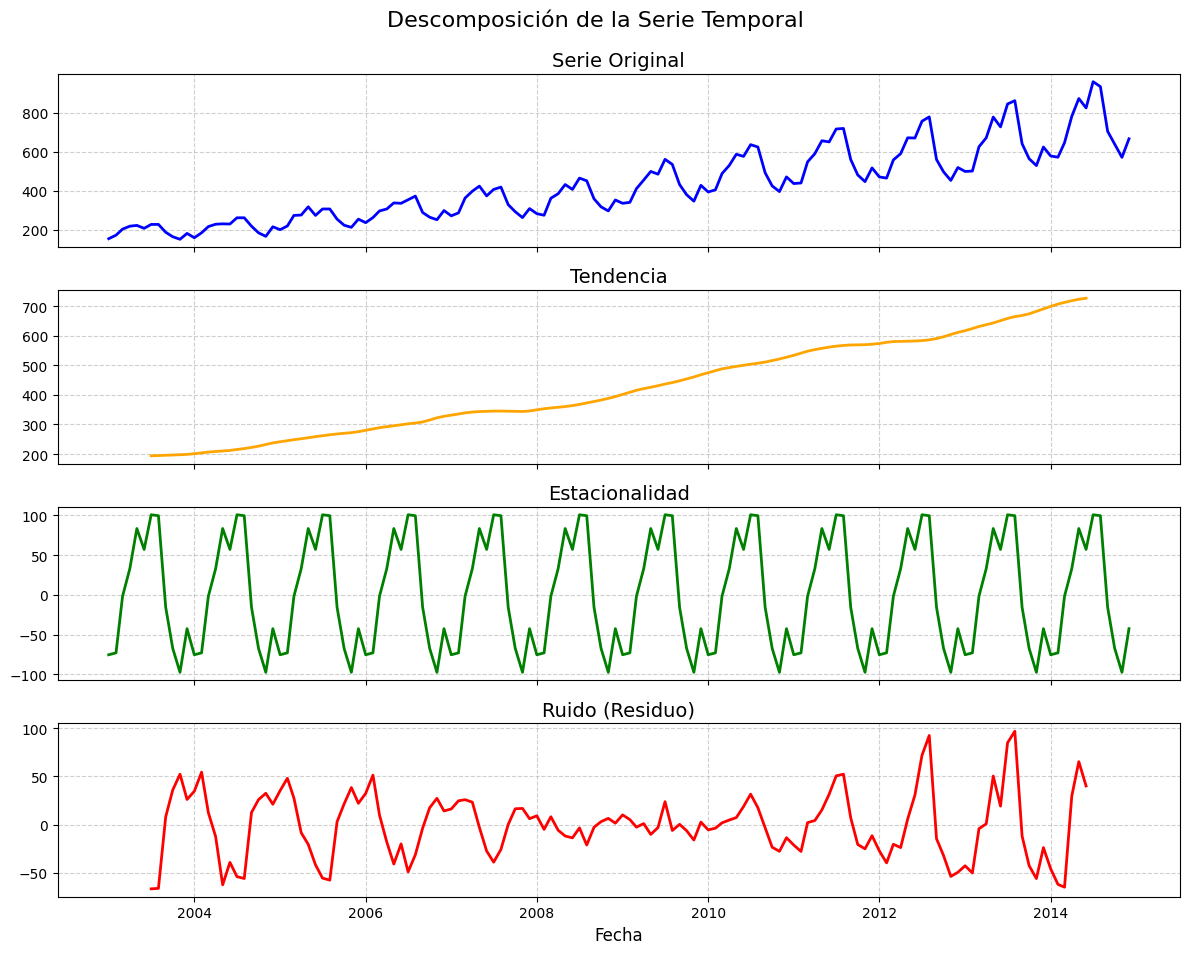

In [65]:
serie.detectar_estacionalidad()

Observando la serie podemos observar que conforme avanzan los años mayor es el número de caminones que se venden, lo que indica una clara tendencia positiva. Sin embargo, este aumento no se hace de forma abrupta sino que va aumentando un poco cada año, por lo que el orden de diferenciación que usaremos para el modelo es d=1.

También podemos observar una clara estacionalidad con un ciclo cada 12 meses.

In [66]:
#Comprobamos la estacionaridad
serie.prueba_estacionariedad()

ADF Statistic: 1.1158932574252591
p-value: 0.9953500083802601
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


Confirmamos la no estacionaridad mediante la prueba de Dickey-Fuller y por lo tanto concluimos que hay una tendencia positiva.

### **Análisis de autocorrelaciones**

<Figure size 1200x1000 with 0 Axes>

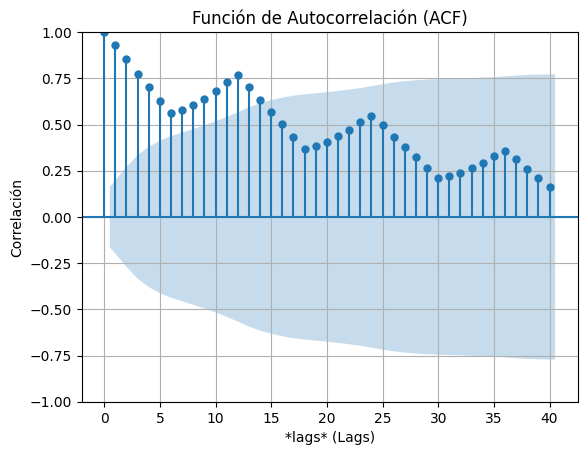

<Figure size 1200x1000 with 0 Axes>

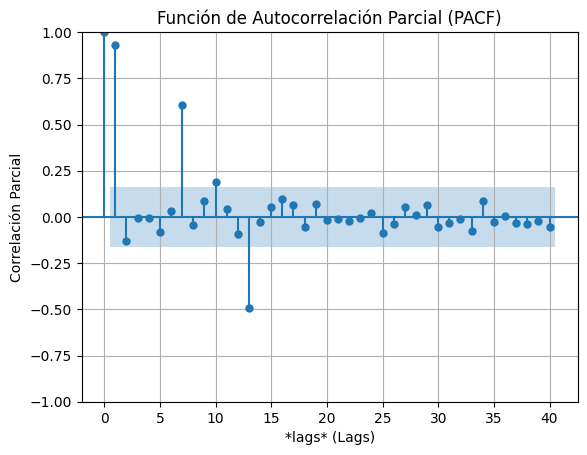

In [71]:
serie.graficar_acf_pacf()

En la gráfica ACF podemos observar de nuevo la estacionalidad cada 12 meses pues cuando compara los mismos meses de distintos años la autocorrelación aumenta respecto a sus valores más cercano, sin embargo cuandto más avanzamos en el tiempo esta autocorrelación va descendiendo pues al tener una tendencia positiva los datos de un año a otro cuanto más timpo pasa más diferencias hay. Del ACF obtenemos el parámetro q = 14 pues son las barritas contando desde el principio que encontramos fuera del intervalo de confianza.

Para la gráfica de LACF vemos cambios más abruptos pues aqui comienza a tener en cuenta no solo el mes con el que se está comparando sino que también entra a jugar un papel todos esos meses que hay de por medio. En este caso obtenemos el parámetro p=2.

### **SARIMAX**

In [133]:
df_final = df.set_index("Date")
df_final.head()

,Number_Trucks_Sold
Date,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


In [134]:
sarima = ss.SARIMAModel()

In [135]:
y_train, y_test = sarima.dividir_train_test(df_final, 0.3)
print(y_train.shape)
print(y_test.shape)

(101, 1)
(43, 1)


In [136]:
# Definir los rangos de parámetros
p_range = range(1, 4)
q_range = range(1, 11)
seasonal_order_ranges = (range(1, 2), range(1, 2), range(1, 2), range(12, 13))  # P, D, Q, S

# Invocar la función
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]

Los mejores parámetros son: {'p': 1, 'q': 9, 'seasonal_order': (1, 1, 1, 12)} con un RMSE de 37.17


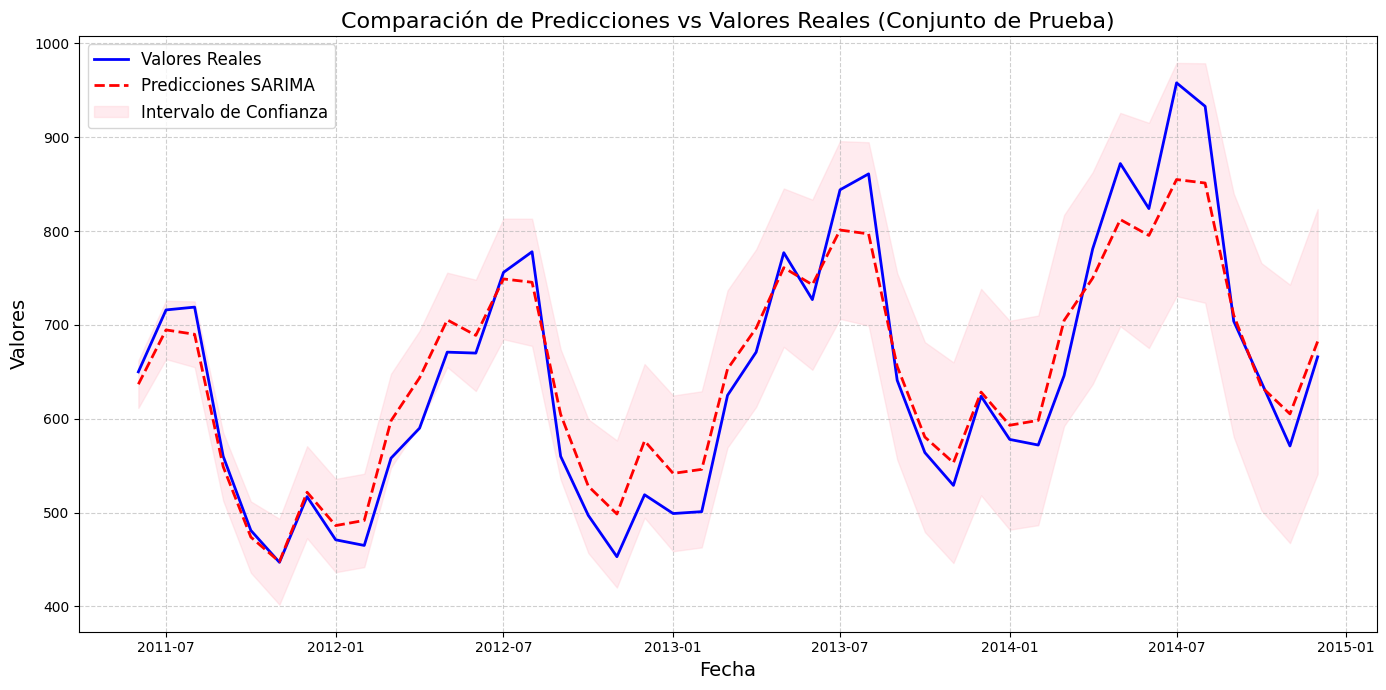

,p,q,seasonal_order,RMSE
8,1,9,"(1, 1, 1, 12)",37.167882
18,2,9,"(1, 1, 1, 12)",37.235310
28,3,9,"(1, 1, 1, 12)",37.707636
9,1,10,"(1, 1, 1, 12)",37.868443
16,2,7,"(1, 1, 1, 12)",38.149628


In [137]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, 1, df.shape[0], "Number_Trucks_Sold")
results_df.head()

Observando la gráfica vemos que la estimación es bastante buena, si que hay algunos meses donde se confunde un poquito más como puede ser en los meses de julia y cuya razón seguramente sean factores externos que están fuera de nuestro control.

Al cambiar el porcentaje del test a 30% hemos obtenido nuestra mejor métrica de RMSE con un 37, lo cual para una mediana de precio de 406, 37 de RMSE no es demasiado. Hagamos una predicción:

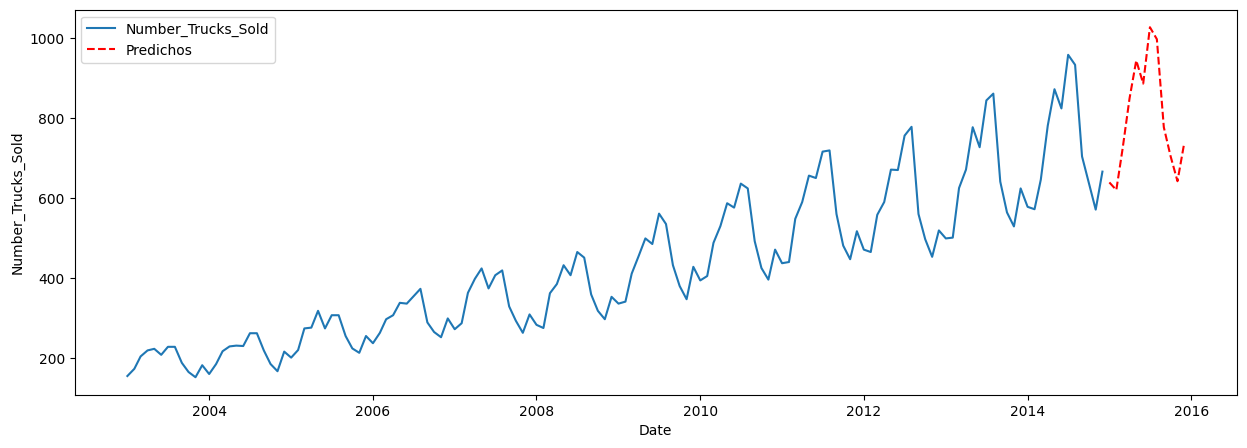

In [ ]:
df_predict = sarima.predict_sarima(df_final, (1,1,9), (1,1,1,12), 12, "Number_Trucks_Sold")

In [153]:
df_predict

,predicted_mean
2015-01-01,639
2015-02-01,620
2015-03-01,723
2015-04-01,849
2015-05-01,944
2015-06-01,886
2015-07-01,1027
2015-08-01,997
2015-09-01,777
2015-10-01,705


Como podemos observar la predicción para elpróximo año tiene buena pinta pues continua con la misma estacionalidad y tendencia que los datos originales.